# GFER-ROS 20181217
_Maydan Wienreb_
<img src="https://raw.githubusercontent.com/maydanw/InEasyReach/master/hr-brian-litzinger-one.png" alt="Drawing" style="width: 100%; height: 60px" />

In [6]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports


In [7]:
"""
This will enable completion on elements of lists, results of function calls, etc.
However, be warned that enabling this option can be unsafe, because the code is actually evaluated upon hitting TAB
"""
%config IPCompleter.greedy=True

from typing import Dict, Tuple, List

# import numpy
import numpy as np
np.random.seed(0) # Remmeber to reset the seed every time if you expect the second draw to be the same as the first.

#import pandas
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import graphics
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [12.0, 8.0]
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# %load_ext autoreload
# %autoreload 1
# %aimport TestFunctions
## See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html


In [8]:
rcParams['figure.figsize'] = [12.0, 8.0]
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
sns.set_style("whitegrid")

In [9]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [10]:
import types
import sys
print ("Basic packages versions:")
print ("   Python version: %s" % (sys.version))
print ("   Packages:")


try:  
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))
except: 
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))

Basic packages versions:
   Python version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
   Packages:
   json: 2.0.9
   numpy: 1.15.0
   pandas: 0.23.3
   seaborn: 0.9.0


# General

In [44]:
patients = {"AV": {'age': 6*4, "gender": "M", "color": "cornflowerblue"}, 
            "EV": {"age": 5.5*12*4, "gender": "F", "color": "violet"},
            "CM": {"age": 6*12*4, "gender": "F", "color": "green"},
            "AG015": {"age": 3/7, "gender": "M", "color": "cyan"}}
patients_df = pd.DataFrame(patients).T
patients_df

age           color gender
AV           24  cornflowerblue      M
EV          264          violet      F
CM          288           green      F
AG015  0.428571            cyan      M

In [45]:
col_map = {2:"AV", 3:"AV", 4:"AV", 5:"EV", 6:"EV", 7:"EV", 8:"AG015", 9:"AG015", 10:"CM", 11:"CM"}
col_map

{2: 'AV',
 3: 'AV',
 4: 'AV',
 5: 'EV',
 6: 'EV',
 7: 'EV',
 8: 'AG015',
 9: 'AG015',
 10: 'CM',
 11: 'CM'}

In [46]:
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, CategoricalColorMapper, LabelSet
from bokeh.palettes import Set3
from bokeh.palettes import d3
from bokeh.models.tools import HoverTool
from bokeh.models import NumeralTickFormatter


def plot_column(df, column_name, agg='50%'):

    TOOLS='pan,wheel_zoom,box_zoom,reset'

    source = ColumnDataSource(df)
    patients_names =  source.data['Pcol'].tolist()
    plot_options = dict(width=750, plot_height=350,tools=TOOLS)
    p = figure(**plot_options, x_range=patients_names)


    # palette = d3['Category10'][len(patients_names)]
    # palette = [patients[pn]['color'] for pn in patients_names]
    # color_map = CategoricalColorMapper(factors=patients_names, palette=palette)
    
    source.data['color'] = [patients[pn]['color'] for pn in patients_names]
    source.data['age'] = [patients[pn]['age']/4/12 for pn in patients_names]
    source.data['gender'] = [patients[pn]['gender'] for pn in patients_names]
    
    cell_count = df["Pcol"].count().to_dict()
    source.data['cell_count'] = [cell_count[pn] for pn in patients_names]

    # renderer = p.vbar(x='Pcol', top='Cox17 IxA_50%', width=0.95, line_color="gray", source=source, color={'field': 'Pcol', 'transform': color_map})
    renderer = p.vbar(x='Pcol', top=f"{column_name}_{agg}", width=0.95, line_color="gray", source=source, color='color')
    
    source.data[f"formatted_{column_name}_{agg}"] = [f"{x:,.4f}" if x<10 else f"{x:,.0f}" for x in source.data[f"{column_name}_{agg}"]]
    labels = LabelSet(x='Pcol', y=f"{column_name}_{agg}", text=f"formatted_{column_name}_{agg}", level='glyph',
        x_offset=-30, y_offset=0, source=source, render_mode='canvas')
    p.add_layout(labels)

    p.add_tools(HoverTool(tooltips= [("Name", "@Pcol"), ("Age", "@age"), ("Gender", "@gender"), ("Cell count", "@cell_count")], renderers=[renderer], mode='mouse'))
    p.yaxis[0].formatter = NumeralTickFormatter(format="0,0.00")

    show(p)

# ROS

## Loading Data

In [47]:
data_path = ".\\Data\\ros SEG. Prtocol221118.2018.12.13.00.00.11.XLS"

In [48]:
df_ros.Pcol.map(col_map)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
24572    NaN
24573    NaN
24574    NaN
24575    NaN
24576    NaN
Name: Pcol, Length: 24577, dtype: object

In [49]:
df_ros = pd.read_excel(data_path, sheet_name='mito_cell_nuc', header=1)

# remove redundent column
df_ros.drop("Target",axis=1, inplace=True)

# rename columns
df_ros.columns = df_ros.columns.str.replace("Mitochondrial", "ROS")
df_ros.rename({"cox total int": "ROS total intensity"}, axis="columns", inplace=True)

# extract the positional data 
loc_df = df_ros.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Prow","Pcol", "Pfield"]
loc_df.Pcol = loc_df.Pcol.astype(np.int16)
df_ros = pd.concat([df_ros, loc_df], axis=1)
df_ros.drop("Section",axis=1, inplace=True)

# # replace rows with patients names and join patients data
df_ros['Pcol'] = df_ros.Pcol.map(col_map)
df_ros = df_ros.join(patients_df, on='Pcol')

df_ros.sample(7)

Nuclear area  Nuclear perimeter  Nuclear IxA  Nuclear intensity  Nuclear 1/form factor Cell cycle Toxicity status  ROS total intensity  ROS count  ROS mean area  ROS mean intensity  ROS total area      ROS IxA     Cell status  Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity    Cell IxA Prow   Pcol Pfield       age           color gender
13132       190.445             50.786   325436.246           1708.823                  0.928  G2M phase  Early toxicity           536459.412         54          0.387            9350.066          20.914   195547.869  Early toxicity    618.444       45.361         136.282               0.418         113.520   70205.766    C  AG015     17  0.428571            cyan      M
927         230.372             54.874   282438.093           1226.011                  0.961  G2M phase  Early toxicity          1507303.510        159          1.226           10658.836         194.881  2077205.194  Early toxicity   1911.419       84.829         265.588               0.341          99.449  190087.925    B     AV      3        24  cornflowerblue      M
15014       143.230             45.145   295652.507           2064.185                  0.883  G2M phase  Early toxicity           319118.988         24         11.122           16677.869         266.918  4451629.759  Early toxicity    752.167       83.501         217.221               0.200         107.619   80947.461    D     AV     17        24  cornflowerblue      M
22811       108.267             38.941   174457.514           1611.360                  0.897  G2M phase  Early toxicity            49893.181         14          0.415            3273.455           5.809    19017.010  Early toxicity    189.072       20.977          59.021               0.682         124.324   23506.140    D  AG015      4  0.428571            cyan      M
7154        166.362             48.753   169497.396           1018.848                  0.880  G2M phase  Early toxicity            94202.081         13          0.382            7227.426           4.964    35880.189  Early toxicity    731.464       45.504         132.495               0.524         100.617   73597.752    C     AV      9        24  cornflowerblue      M
16991       160.024             55.164   263269.508           1645.185                  0.661  G2M phase  Early toxicity           316662.275         34          1.212            7166.549          41.194   295221.445  Early toxicity    989.510       63.214         188.836               0.349          99.561   98516.120    D     AV      9        24  cornflowerblue      M
23531       200.374             53.914   261453.365           1304.829                  0.866  G2M phase  Early toxicity           375681.415         31          1.039           11651.016          32.216   375350.405  Early toxicity    311.915       32.507          90.057               0.483         117.571   36672.283    D  AG015     15  0.428571            cyan      M

In [50]:
df_ros.describe()

Nuclear area  Nuclear perimeter   Nuclear IxA  Nuclear intensity  Nuclear 1/form factor  ROS total intensity     ROS count  ROS mean area  ROS mean intensity  ROS total area       ROS IxA     Cell area   Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA
count  24577.000000       24577.000000  2.457700e+04       24577.000000           24577.000000         2.457700e+04  24577.000000   24577.000000        24577.000000    24577.000000  2.457700e+04  24577.000000  24577.000000    24577.000000        24577.000000    24577.000000  2.457700e+04
mean     189.465872          52.431533  2.369375e+05        1296.481064               0.855201         2.945399e+05     28.131057       2.697535        10938.039664       54.584096  7.641111e+05   1364.373418     82.479064      249.877451            0.321588      105.662121  1.417194e+05
std       53.300858           7.683051  6.981860e+04         347.055208               0.075947         3.262079e+05     30.504556       7.538772         5138.887396       82.859035  1.491780e+06   1236.879376     41.898744      141.167548            0.175057       13.139226  1.262227e+05
min      100.240000          36.785000  1.640983e+04         111.507000               0.166000         1.050000e+03      1.000000       0.106000         1050.000000        0.106000  1.109080e+02    101.190000     14.424000       40.452000            0.032000       98.176000  1.009431e+04
25%      150.518000          47.520000  1.991487e+05        1053.396000               0.820000         7.508127e+04      9.000000       0.584000         7625.814000        7.394000  6.236151e+04    620.662000     51.441000      150.257000            0.191000      100.062000  6.645370e+04
50%      185.269000          51.852000  2.189554e+05        1239.001000               0.872000         1.959282e+05     19.000000       1.086000         9771.000000       23.660000  2.144381e+05   1034.507000     75.704000      224.593000            0.277000      101.264000  1.081235e+05
75%      218.858000          55.992000  2.472821e+05        1490.666000               0.909000         4.032544e+05     37.000000       2.095000        13131.688000       66.122000  7.352353e+05   1682.737000    104.926000      315.386000            0.412000      104.196000  1.737752e+05
max      811.635000         183.758000  2.077598e+06       14526.791000               0.981000         4.954018e+06    466.000000     239.667000        41378.583000     1808.961000  5.182574e+07  18029.824000    516.055000     1710.685000            0.972000      311.214000  1.879846e+06

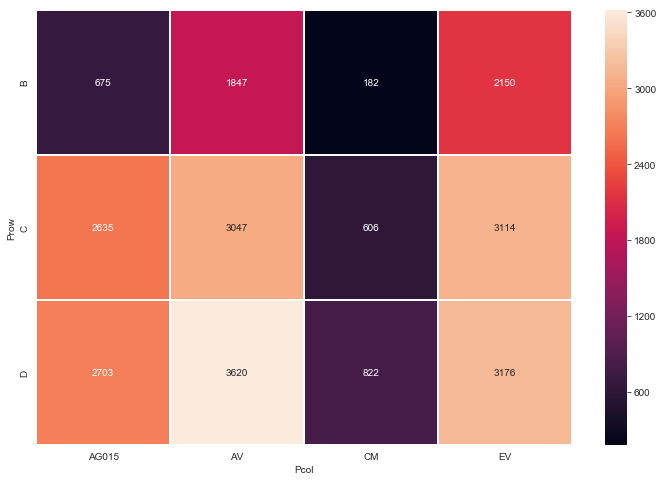

In [51]:
cell_in_well = df_ros.groupby(["Prow", "Pcol"])["Pfield"].count()
cell_in_well = cell_in_well.unstack(level=-1)

cell_in_well = cell_in_well.rename(col_map, axis=1)

display(sns.heatmap(cell_in_well, linewidths=0.5,annot=True, fmt="0.00f"))

## Group by patient


In [52]:
df_ros["ROS area ratio*"] = df_ros['ROS total area']/df_ros['Cell area']
df_ros["ROS total intensity ratio*"] = df_ros["ROS total intensity"]/df_ros['Cell intensity']
df_ros["ROS IxA ratio*"] = df_ros["ROS IxA"]/df_ros['Cell IxA']

In [53]:
ros_features = df_ros.columns[df_ros.columns.str.contains("ROS")].tolist()
ros_features.remove('ROS count')
ros_features.remove('ROS mean area')
ros_features.remove('ROS mean intensity')

In [54]:
df_grp_row = df_ros.groupby("Pcol")

ros_medians = df_grp_row[ros_features].median()
display(ros_medians)

ROS total intensity  ROS total area      ROS IxA  ROS area ratio*  ROS total intensity ratio*  ROS IxA ratio*
Pcol                                                                                                                
AG015          262154.2000         32.7440  324984.2700         0.039130                 2385.941744        3.623577
AV             219545.0900         25.5620  232412.0750         0.020455                 2117.324740        1.772110
CM             260469.9865         39.1345  499814.9625         0.044049                 1986.686344        4.835800
EV             108859.7975         16.2660  138264.2480         0.011891                 1084.656195        0.975113

In [55]:
plot_column(df_grp_row, 'ROS total area')

In [56]:
plot_column(df_grp_row, 'ROS total intensity')

In [57]:
plot_column(df_grp_row, 'ROS area ratio*')

In [58]:
plot_column(df_grp_row, 'ROS IxA')

In [59]:
plot_column(df_grp_row, 'ROS IxA ratio*')

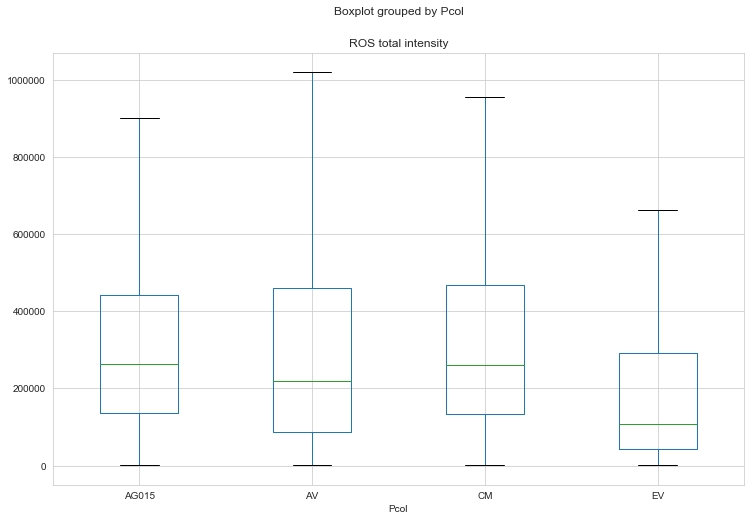

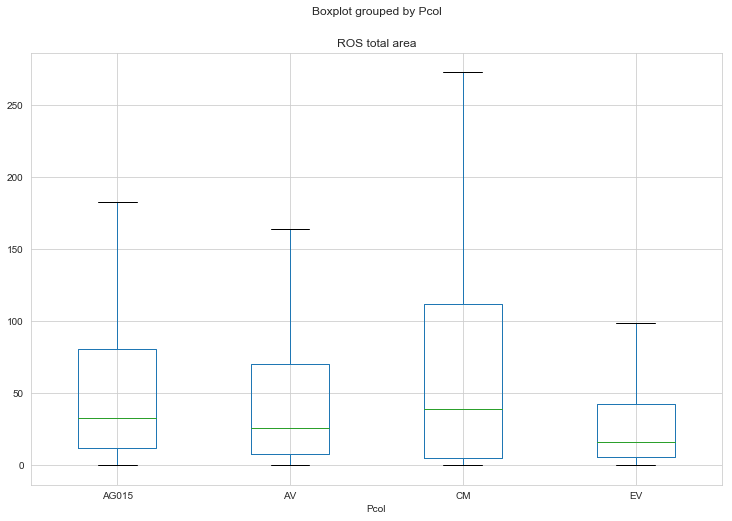

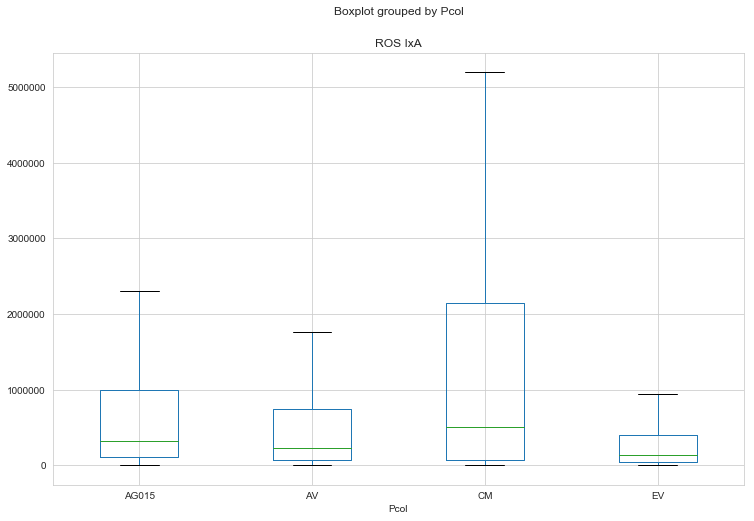

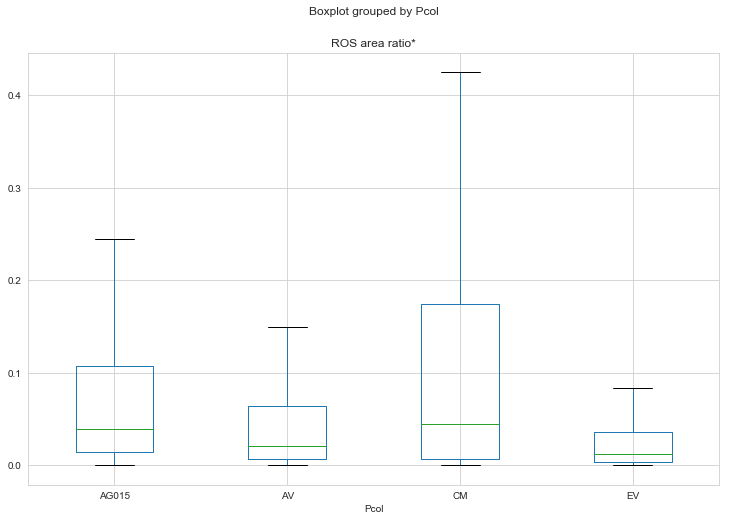

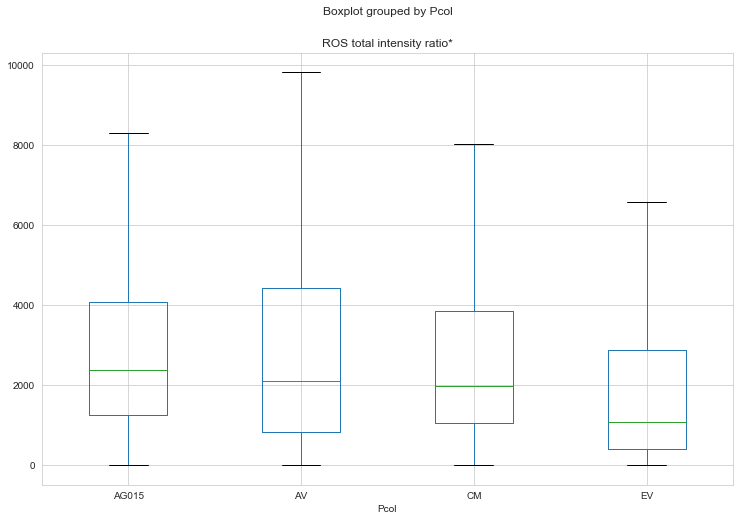

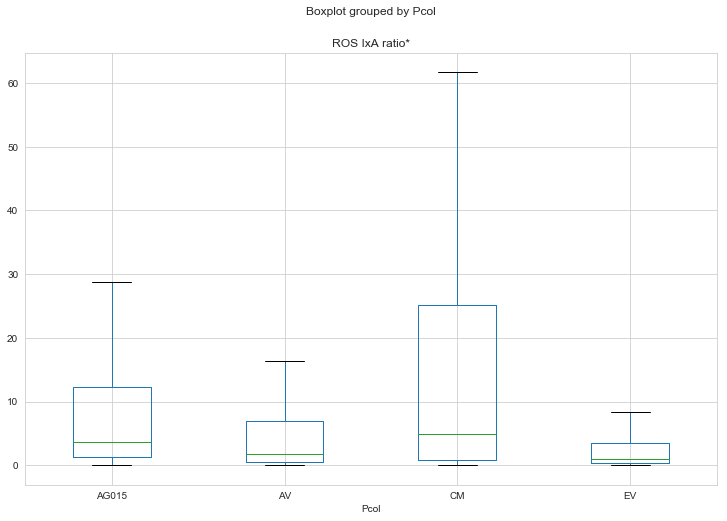

In [60]:
for feature in ros_features:
    df_ros.boxplot(column=feature, by='Pcol', showfliers=False)